# Library importing

In [1]:
import os
import sys
import pandas as pd
from PIL import Image
import numpy as np
import time
import pickle
from IPython import display
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, datasets, utils, models
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Version control
1.python version

2.torch version

3.hardware configuration

In [2]:
print("Python version", sys.version)
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

Python version 3.9.17 (main, Jul  5 2023, 20:47:11) [MSC v.1916 64 bit (AMD64)]
Torch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118


# Setting Global Seed
tbd

In [2]:
import random

def global_seeds(seed_value=0):
    np.random.seed(seed_value) # random seed for the NumPy library
    torch.manual_seed(seed_value) # random seed for PyTorch's CPU-based RNG (random number generator)
    torch.cuda.manual_seed(seed_value) # random seed for PyTorch's GPU-based RNG
    torch.cuda.manual_seed_all(seed_value) # random seed to ensure multiple GPUs are synchronised
    torch.backends.cudnn.deterministic = True # set CuDNN (CUDA Deep Neural Network library) to deterministic
    torch.backends.cudnn.benchmark = False # disable the benchmark mode of CuDNN
    random.seed(seed_value) # python built-in RNG

global_seeds(42)

# Data Import and preprocessing
Determine what type of data are used for training

In [ ]:
#=========================modify as need=============================#
path = None
# absolute address of the:   
    # 1. folder for image data
    # 2. CSV file for tabular data
data_type = 0  
    # 0 for image data
    # 1 for CSV file 
#====================================================================#

Image dataset should be stored in a folder has the following structure:  

&ensp;data_dir/  
&ensp;  &ensp;class_1/  
&ensp;  &ensp;  &ensp;image1.jpg  
&ensp;  &ensp;  &ensp;image2.jpg  
&ensp;  &ensp;class_2/  
&ensp;  &ensp;  &ensp;image3.jpg  
&ensp;  &ensp;  &ensp;image4.jpg  

In [3]:
cifar10trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar10testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(cifar10trainset.data[0].transpose(2,0,1).shape)

(3, 32, 32)


In [4]:
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, data, labels, random_crop = False, random_rotation = False, resize = False):
        self.data = data
        self.labels = labels
        transforms_list = [
            transforms.ToTensor(),  # Convert to tensor and map to range [0,1]
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]) # Normalisation
        ]
        if resize:
            transforms_list.insert(0, transforms.Resize(resize)) # resize the image to a fixed size
        if random_rotation:
            transforms_list.insert(0, transforms.RandomRotation(random_rotation)) # Random rotation within a given angle
        if random_crop:
            transforms_list.insert(0, transforms.RandomCrop(random_crop))  # Random crop to a fixed size
        self.transform = transforms.Compose(transforms_list)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]
        image = Image.fromarray(image)
        # image = torch.from_numpy(image.transpose(2,0,1))
        image = self.transform(image)
        return image, label

In [13]:
trainset = CustomCIFAR10Dataset(cifar10trainset.data, cifar10trainset.targets, random_crop = 31, random_rotation = 10, resize = 64) # resize need to be greater than 224 for pretrained model
testset = CustomCIFAR10Dataset(cifar10testset.data, cifar10testset.targets, random_crop = False, random_rotation = False, resize = 64)

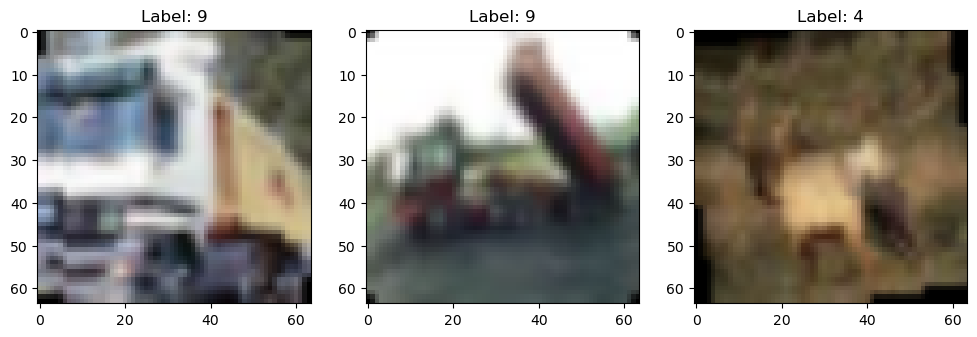

In [24]:
global_seeds(42)
example_data1, example_label1 = trainset[1]
example_data2, example_label2 = trainset[2]
example_data3, example_label3 = trainset[3]
# print(trainset.transform)
# print(example_data.shape)
image_np1 = example_data1.numpy().transpose((1, 2, 0))
image_np1 = np.uint8(((image_np1 * 0.25) + 0.5) * 255)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image_np1)  # permute to (height, width, channels)
plt.title(f"Label: {example_label1}")

image_np2 = example_data2.numpy().transpose((1, 2, 0))
image_np2 = np.uint8(((image_np2 * 0.25) + 0.5) * 255)
plt.subplot(132)
plt.imshow(image_np2)  # permute to (height, width, channels)
plt.title(f"Label: {example_label2}")

image_np3 = example_data3.numpy().transpose((1, 2, 0))
image_np3 = np.uint8(((image_np3 * 0.25) + 0.5) * 255)
plt.subplot(133)
plt.imshow(image_np3)  # permute to (height, width, channels)
plt.title(f"Label: {example_label3}")
plt.show()

In [25]:
global_seeds(42)
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Input shape: torch.Size([64, 3, 64, 64])
Labels shape: torch.Size([64])


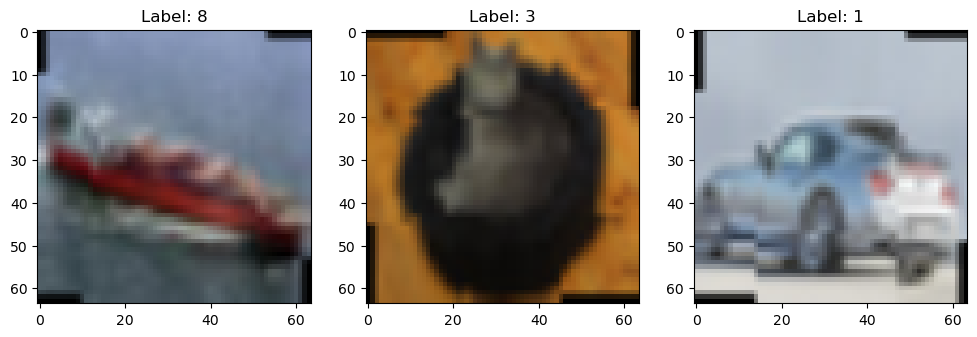

In [26]:
global_seeds(36)
for batch in trainloader:
    # Unpack the batch into input data and labels (if applicable)
    inputs, labels = batch

    # Do something with the data in the current batch
    # For example, print the shapes of inputs and labels
    print(f"Input shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")

    example_data1, example_label1 = inputs[1], labels[1]
    example_data2, example_label2 = inputs[2], labels[2]
    example_data3, example_label3 = inputs[3], labels[3]
    image_np1 = example_data1.numpy().transpose((1, 2, 0))
    image_np1 = np.uint8(((image_np1 * 0.25) + 0.5) * 255)
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(image_np1)  # permute to (height, width, channels)
    plt.title(f"Label: {example_label1}")

    image_np2 = example_data2.numpy().transpose((1, 2, 0))
    image_np2 = np.uint8(((image_np2 * 0.25) + 0.5) * 255)
    plt.subplot(132)
    plt.imshow(image_np2)  # permute to (height, width, channels)
    plt.title(f"Label: {example_label2}")

    image_np3 = example_data3.numpy().transpose((1, 2, 0))
    image_np3 = np.uint8(((image_np3 * 0.25) + 0.5) * 255)
    plt.subplot(133)
    plt.imshow(image_np3)  # permute to (height, width, channels)
    plt.title(f"Label: {example_label3}")
    plt.show()
    break

In [ ]:
class Load_Dataset(Dataset):
    def __init__(self, data_type, path, random_crop = False, random_rotation = False, resize = False, label_file=None):
        self.data_type = data_type
        self.path = path
        self.label_file = label_file
        self.random_crop = random_crop
        self.random_rotation = random_rotation
        self.resize = resize
        self.transform = self._get_transform()

    def _get_transform(self):
        # Define data transformations for images
        # Define a list of transformations
        transforms_list = [
            transforms.ToTensor(),  # Convert to tensor and map to range [0,1]
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]) # Normalisation
        ]
        if self.resize:
            transforms_list.insert(0, transforms.Resize(self.resize)) # resize the image to a fixed size
        if self.random_rotation:
            transforms_list.insert(0, transforms.RandomRotation(self.random_rotation)) # Random rotation within a given angle
        if self.random_crop:
            transforms_list.insert(0, transforms.RandomCrop(self.random_crop))  # Random crop to a fixed size

        self.transforms = transforms.Compose(transforms_list)


    def load_data(self):
        if self.data_type == "image":
            if self.label_file is None:
                # Load image dataset using ImageFolder (labels from directory structure)
                dataset = datasets.ImageFolder(root=self.path, transform=self.transform)
            else:
                # Load labels from CSV file
                labels_df = pd.read_csv(self.label_file)
                dataset = datasets.ImageFolder(root=self.data_dir, transform=self.transform)
                dataset.samples = [(image_path, labels_df[labels_df['filename'] == os.path.basename(image_path)]['label'].values[0]) for image_path, _ in dataset.samples]
            return dataset

        elif self.data_type == "table":
            if self.label_file is None:
                raise ValueError("Label file is required for tabular data.")
            else:
                # Load tabular data from CSV (modify as needed)
                dataframe = pd.read_csv(self.label_file)
                X = dataframe.drop(columns=['target_column'])  # Features
                y = dataframe['target_column']  # Labels
                return X, y

        else:
            raise ValueError("Invalid data type. Please enter 'image' or 'table'.")

# Example usage:
data_loader = DataLoader(data_type="image", data_dir="image_data", label_file="labels.csv")
image_dataset = data_loader.load_data()

data_loader = DataLoader(data_type="table", data_dir=None, label_file="table_data.csv")
X, y = data_loader.load_data()

# Network design
build yourself or by importing

In [ ]:
# Residual block definition
class Resblock(nn.Module):
    def __init__(self,in_channels,out_channels,stride = 1):
        super(Resblock,self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride=stride, padding = 1,bias = False) 
        self.bn1 = nn.BatchNorm2d(out_channels) 
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride=1, padding=1, bias = False)       
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, stride = stride,
                                                    kernel_size = 1, bias = False),
                                          nn.BatchNorm2d(out_channels))
            
    def forward(self,x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(identity)
        out = self.relu(out)
        return out

In [ ]:
## Resnet
class ResNet(nn.Module):
    def __init__(self,num_class = 2, input_channel = 3):
        super(ResNet,self).__init__()
        self.conv1 = nn.Conv2d(input_channel, 64, kernel_size = 7, stride=2,padding =3, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.layer1 = self._make_layer(64, 64, 2,stride = 1)
        self.layer2 = self._make_layer(64, 128, 2,stride = 2)
        self.layer3 = self._make_layer(128, 256, 2,stride = 2)
        self.layer4 = self._make_layer(256, 512, 2,stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,num_class)
        self.dropout = nn.Dropout(p=0.3)
     
    def _make_layer(self,in_channels,out_channels,blocks,stride = 1):
        layer = []
        layer.append(Resblock(in_channels, out_channels,stride))
        for _ in range (1,blocks):
            layer.append(Resblock(out_channels, out_channels))
        return nn.Sequential(*layer)
    
    def forward(self,x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        
        out = torch.flatten(out,1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return (out)

In [ ]:
model = ResNet().cuda()

Pytorch pretrained model for testing

In [13]:
#pretrained AlexNet model
num_classes = 10
model = models.alexnet(weights ='AlexNet_Weights.IMAGENET1K_V1')
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
model = model.cuda()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
num_classes = 10
global_seeds(42)
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.cuda()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#pretrained VGG-16 model
model = models.vgg16(pretrained=True).cuda()

# Training hyperparameter configuration

In [31]:
num_epochs = 16
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.5)

## Training process tracking

The display block tracks the loss through training

In [10]:
class DisplayBlock:
    def __init__(self, names, time_slot=60):
        self.start_time = time.time()
        self.time_slot = time_slot
        self.annotations = []
        self.data = {}
        for name in names:
            self.data[name] = []
    
    def update(self, data_dict):
        for key in data_dict:
            self.data[key].append(data_dict[key])
        current_time = time.time() - self.start_time
        idx = len(self.data[key]) -1
        if len(self.annotations) == 0:
            if current_time > self.time_slot:
                self.annotations.append((idx, current_time))
        elif current_time - (self.annotations[-1][1]//self.time_slot)*self.time_slot > self.time_slot:
            self.annotations.append((idx, current_time))
    
    def draw(self):
        all_keys = list(self.data.keys())
        fig, ax = plt.subplots(nrows=1, ncols=len(all_keys))
        fig.set_figwidth(20)
        for idx in range(len(all_keys)):
            ax[idx].plot(self.data[all_keys[idx]])
            ax[idx].set_title(all_keys[idx])
            for an in self.annotations:
                ax[idx].annotate(f'{int(an[1])}s', xy=(an[0], self.data[all_keys[idx]][an[0]]),
                    xytext=(0, -40), textcoords="offset points",
                    va="center", ha="left",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
        display.clear_output(wait=True)
        plt.show()

# Training

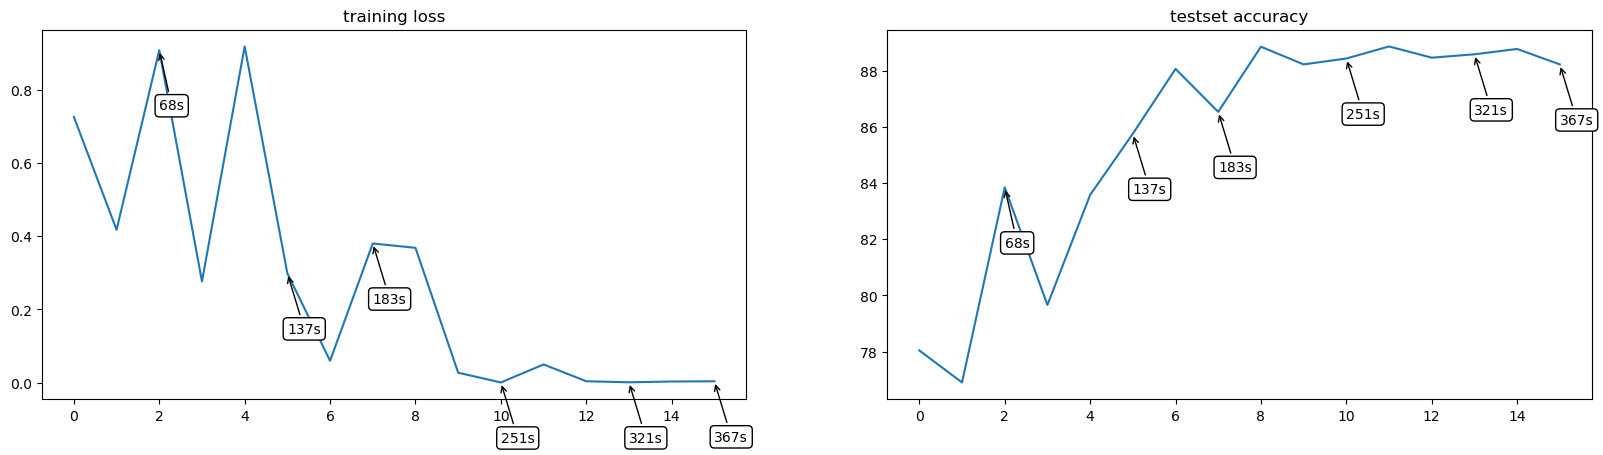

Epoch [16/16] - Training Loss: 0.01876, Testset Accuracy: 88.23%, Learning Rate: 0.000125
Training finished


In [32]:
global_seeds(42)
db = DisplayBlock(['training loss', 'testset accuracy'], time_slot=60)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels, in trainloader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images).cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()                
        running_loss += loss.item()
    
    scheduler.step()
    # obtain the current learning rate 
    current_lr = optimizer.param_groups[0]['lr']
    # print the loss and the learning rate
    # print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(trainingloader)}, Learning Rate: {current_lr}")
    print ("Training complete")

    # Evaluation on testset
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            # find the index with the highest probability
            predicted = outputs.argmax(dim=1)
            # match the prediction with labels
            comparison = predicted == labels
            total_predictions += predicted.size(0)
            correct_predictions += comparison.sum()
    trainingloss = loss.item()
    testset_accuracy = (100 * correct_predictions / total_predictions).cpu()
    display.clear_output(wait=True)
    db.update({'training loss': trainingloss, 'testset accuracy': testset_accuracy})
    db.draw()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {(running_loss / len(trainloader)):.5f}, Testset Accuracy: {testset_accuracy:.2f}%, Learning Rate: {current_lr}")


print("Training finished")

## Model evaluation

In [33]:
global_seeds(42)
True_label = []
predicted_label = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        # find the index with the highest probability
        predicted = outputs.argmax(dim=1)

        True_label.extend(labels.cpu().numpy())
        predicted_label.extend(predicted.cpu().numpy())

# Accuracy
accuracy = accuracy_score(True_label, predicted_label)
print(f'Accuracy: {accuracy:.2f}')

# Precision
precision = precision_score(True_label, predicted_label, average='weighted')
print(f'Precision: {precision:.2f}')

# Recall
recall = recall_score(True_label, predicted_label, average='weighted')
print(f'Recall: {recall:.2f}')

# F1 Score
f1 = f1_score(True_label, predicted_label, average='weighted')
print(f'F1 Score: {f1:.2f}')

# Classification Report
class_report = classification_report(True_label, predicted_label)
print('Classification Report:')
print(class_report)

Accuracy: 0.88
Precision: 0.89
Recall: 0.88
F1 Score: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1000
           1       0.92      0.96      0.94      1000
           2       0.84      0.87      0.86      1000
           3       0.72      0.79      0.75      1000
           4       0.91      0.85      0.88      1000
           5       0.76      0.85      0.80      1000
           6       0.94      0.87      0.90      1000
           7       0.95      0.91      0.93      1000
           8       0.96      0.91      0.94      1000
           9       0.96      0.90      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

